In [1]:
import os
import sys
import copy
import random
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from joblib import dump
from pathos.multiprocessing import ProcessingPool as Pool

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))
import CPC_package as CPC

In [2]:
CORES = 12

In [3]:
G = nx.powerlaw_cluster_graph(1000, 4, 0.4)
seed_function = CPC.randomFactorSeed

In [4]:
T_s = [1, 0.05, 0.1, 0.2]

handlers = []
graphs = []
node_cpc_values = []
graphs_undirected = []

for T in tqdm(T_s):
    handler = CPC.CpcHandler(G.copy(), cores=CORES, seed_function=seed_function)
    handler.to_dict_representation()
    handler.setThresholds(T)
    handler.setRandomFactor(0)
    handler.calcCPC(tqdm_bar=False)
    handlers.append(handler)
    graphs.append(handler.getNetworkWithCPC())
    graphs_undirected.append(copy.deepcopy(G))

    for node in graphs_undirected[0].nodes():
        graphs_undirected[-1].nodes[node]["CPC"] = graphs[-1].nodes.get(node, {}).get("CPC", 0)

100%|██████████| 4/4 [00:28<00:00,  7.13s/it]


In [5]:
pos = nx.spring_layout(graphs_undirected[0], center=(0,0), scale=0.5)

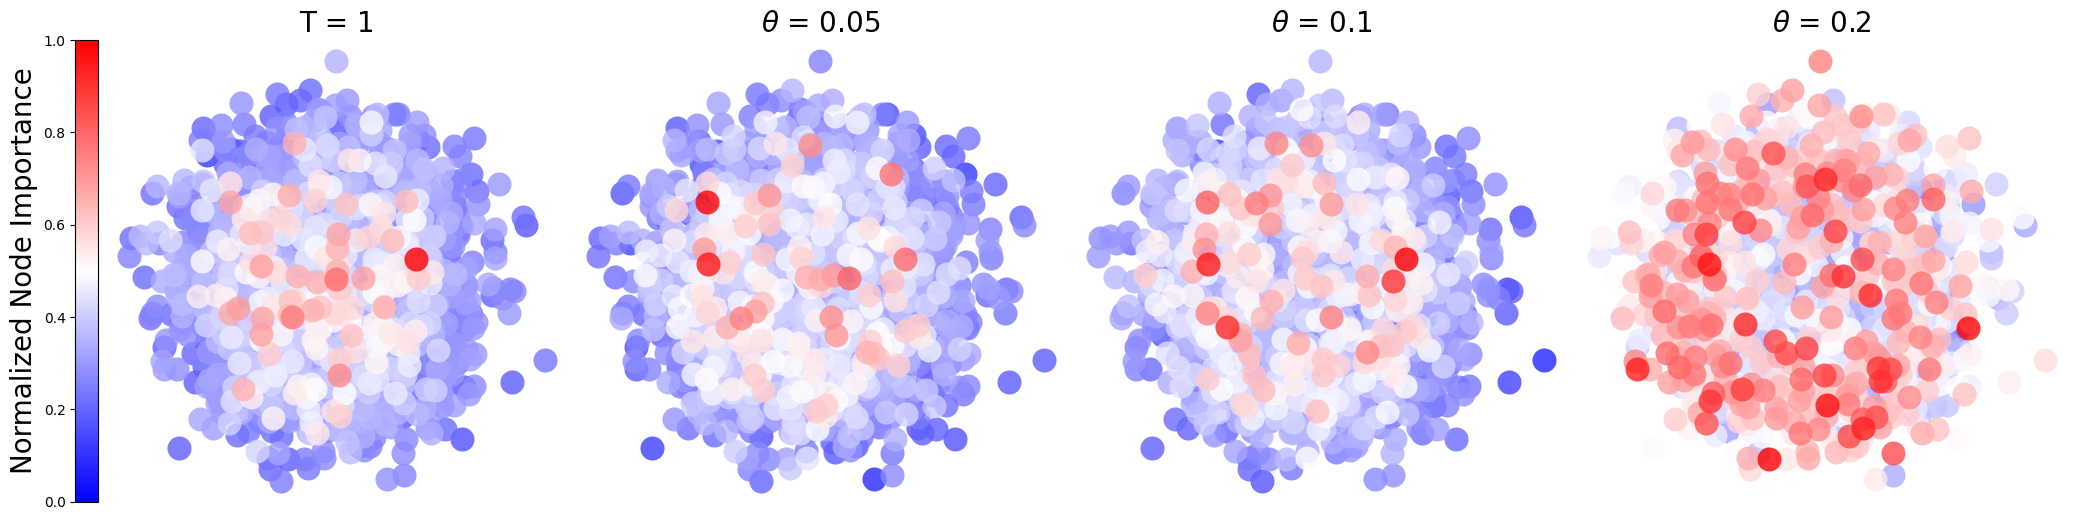

In [6]:
# Figure 5a

# Define blue-to-red colormap
node_cmap = plt.cm.bwr

fig, axs = plt.subplots(1, len(T_s), figsize=(20, 5), constrained_layout=True)

all_color_values = []  # Collect for consistent normalization

# Precompute all transformed values for normalization across subplots
for G in graphs_undirected:
    cpc_values = np.array([
        G.nodes[node]['CPC'] / G.degree(node) if G.degree(node) > 0 else 0
        for node in G.nodes
    ])
    cpc_norm = (cpc_values - np.min(cpc_values)) / (np.max(cpc_values) - np.min(cpc_values))
    cpc_scaled = np.exp(4 * cpc_norm) - 1
    cpc_scaled /= np.max(cpc_scaled)
    cpc_final = cpc_scaled ** 0.25
    all_color_values.append(cpc_final)

# Global min/max for normalization
flat_color_values = np.concatenate(all_color_values)
vmin, vmax = np.min(flat_color_values), np.max(flat_color_values)

for ax, T, G, node_colors in zip(axs, T_s, graphs_undirected, all_color_values):    
    # Map node to its final color
    node_color_dict = dict(zip(G.nodes, node_colors))

    # Sort nodes by value (low first, high last)
    sorted_nodes = sorted(G.nodes, key=lambda n: node_color_dict[n])

    for node in sorted_nodes:
        nx.draw_networkx_nodes(
            G,
            pos={node: pos[node]},
            nodelist=[node],
            node_color=[node_color_dict[node]],
            cmap=node_cmap,
            vmin=vmin, vmax=vmax,
            node_size=300,
            alpha=0.8,
            linewidths=0,
            ax=ax
        )

    # Set title
    if T == 1:
        ax.set_title(r"T = {}".format(T), fontsize=20)
    else:
        ax.set_title(r"$\theta$ = {}".format(T), fontsize=20)
    ax.axis('off')

# Create ScalarMappable for colorbar
sm = ScalarMappable(cmap=node_cmap, norm=Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])  # Required for colorbar

# Add a new axes for the colorbar to the left of the first subplot
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("left", size="5%", pad=0.1)

# Create and configure the colorbar
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label(r"Normalized Node Importance", fontsize=20)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('left')

plt.savefig("CPC_over_degree_comparison_with_colorbar.png", dpi=300, bbox_inches='tight')
plt.show()